# Final-week Prediction Accuracy

In this notebook, any specified model which adheres to the sklearn API can be fitted across ~60 year-long training windows starting in 2021, and predictions made and plotted for the final week of data. Models are persisted to disk for repeated runs.

In [79]:
import os
from joblib import dump, load
import numpy as np
import pandas as pd
import seaborn as sns
from tscv import GapRollForward
from tqdm.notebook import tqdm

# --- notebook parameters: import, choose model, set hyperparameters
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

MODEL_SELECTION = 'rf'
MODELS_DEFINITION = {
    'rf': {
        'class': RandomForestRegressor,
        'kwargs': {
            'n_jobs': 8
        }
    },
    'gb': {
        'class': GradientBoostingRegressor,
        'kwargs': {}
    },
    'ada': {
        'class': AdaBoostRegressor,
        'kwargs': {}
    },
    'knn': {
        'class': KNeighborsRegressor,
        'kwargs': {}
    }
}
# --- end notebook parameters

MODEL = MODELS_DEFINITION[MODEL_SELECTION]['class']
MODEL_KWARGS = MODELS_DEFINITION[MODEL_SELECTION]['kwargs']
model_dir = f'../models/sa/{MODEL_SELECTION}'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

# import and preprocess SA data
df = pd.read_csv(os.path.relpath('../data/merged_interpolated.csv'))
df.datetime = df.datetime.astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['day_of_week'] = dt.day_of_week
df['week'] = dt.isocalendar().week
X_inds = list(range(1, 8)) + list(range(11, 18))
y_ind = 9

df_2021 = df[df['year'] >= 2021]

# specify rolling training window strategy
obs_year = 48*365
obs_week = 48*7
tscv = GapRollForward(min_train_size=obs_year, max_train_size=obs_year,
                      min_test_size=obs_week, max_test_size=obs_week,
                      roll_size=obs_week)

# load persisted models if they exist, otherwise train and persist new models
models, train_ends = [], []

for i, (train_ind, test_ind) in tqdm(enumerate(tscv.split(df_2021))):
    X_train, X_test = df_2021.iloc[train_ind, X_inds], df_2021.iloc[test_ind, X_inds]
    y_train, y_test = df_2021.iloc[train_ind, y_ind], df_2021.iloc[test_ind, y_ind]

    # train or load
    begin, end = df_2021.iloc[[train_ind[0], train_ind[-1]], 0].dt.date
    argstring = '_'.join([f'{k}={v}' for k, v in MODEL_KWARGS.items()])
    model_filename = os.path.join(model_dir, f'{begin}_{end}_{argstring}.joblib')
    try:
        model = load(model_filename)
    except FileNotFoundError:
        model = MODEL(**MODEL_KWARGS)
        model.fit(X_train, y_train)
        dump(model, model_filename)
    
    models.append(model)
    train_ends.append(df_2021.iloc[train_ind[-1], 0])

# predict final week with each model
test_cutoff = df['datetime'].max() - pd.DateOffset(weeks=1)
final_week = df[df['datetime'] >= test_cutoff]

prdfs = []
for i, (model, end) in enumerate(zip(models, train_ends)):
    prd = model.predict(final_week.iloc[:, X_inds])
    prdf = pd.DataFrame({'datetime': final_week['datetime'], 
                        'model': i,
                        'train_end': end,
                        'ahead': final_week['datetime'] - train_ends[i],
                        'predicted': prd,
                        'net_load': final_week['net_load']})
    prdfs.append(prdf)

predictions = pd.concat(prdfs)
predictions['residual'] = predictions['predicted'] - predictions['net_load']
predictions['pe'] = predictions['residual'] / predictions['net_load']
predictions['ape'] = predictions['pe'].abs()
prediction_summary = predictions.groupby('train_end').describe()

print(MODEL_SELECTION, 'MAPE:', predictions['ape'].mean())

0it [00:00, ?it/s]

rf MAPE: 0.10960820790006444


[Text(0.5, 1.0, 'Residual Quantiles')]

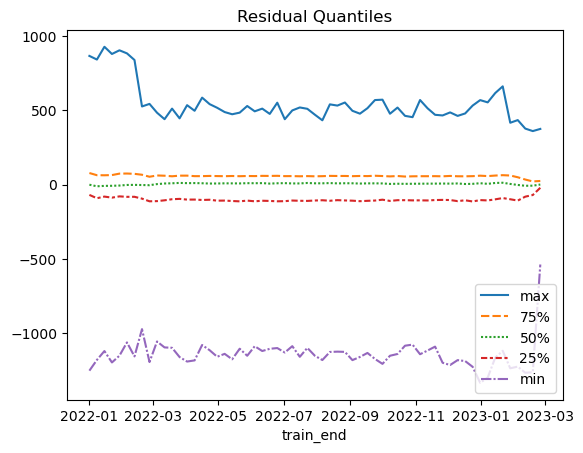

In [80]:
p = sns.lineplot(prediction_summary['residual'][['max', '75%', '50%', '25%', 'min']])
p.set(title='Residual Quantiles')

[Text(0.5, 1.0, 'Percentage Error Quantiles')]

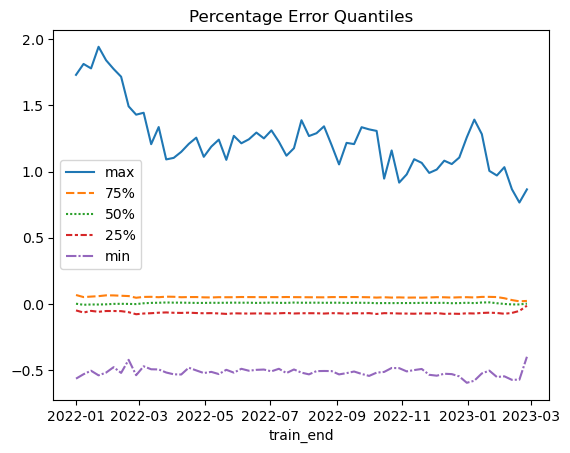

In [81]:
p2 = sns.lineplot(prediction_summary['pe'][['max', '75%', '50%', '25%', 'min']])
p2.set(title='Percentage Error Quantiles')

[Text(0.5, 1.0, 'Absolute Percentage Error Quantiles')]

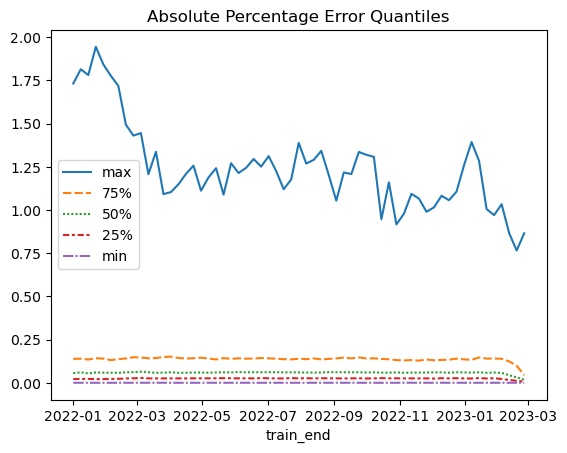

In [82]:
p2 = sns.lineplot(prediction_summary['ape'][['max', '75%', '50%', '25%', 'min']])
p2.set(title='Absolute Percentage Error Quantiles')